<a href="https://colab.research.google.com/github/tarunsharma-1/Time_Series_Prediction_model_using_Deep_Learning-/blob/main/TIme_series_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
EPOCHS = 100
INLEN = 32
HIDDEN = 64
LSTMLAYERS = 2
ATTHEADS = 1
DROPOUT = 0.1
BATCH = 8 #32

N_FC = 24           # default forecast horizon
RAND = 42           # set random state
N_SAMPLES = 100     # number of times a prediction is sampled from a probabilistic model
N_JOBS = 3          # parallel processors to use;  -1 = all processors

# default quantiles for QuantileRegression
QUANTILES = [0.01, 0.05, 0.1, 0.2, 0.25, 0.5, 0.75, 0.8, 0.9, 0.95, 0.99]

TRAIN = "20160101"  # train/test split
MSEAS = 60          # max seasonality to check: months
ALPHA = 0.05        # significance level for seasonality test
FIGSIZE = (9, 6)

qL1, qL2, qL3 = 0.01, 0.05, 0.10        # percentiles of predictions: lower bounds
qU1, qU2, qU3 = 1-qL1, 1-qL2, 1-qL3     # upper bounds derived from lower bounds
label_q1 = f'{int(qU1 * 100)} / {int(qL1 * 100)} percentile band'
label_q2 = f'{int(qU2 * 100)} / {int(qL2 * 100)} percentile band'
label_q3 = f'{int(qU3 * 100)} / {int(qL3 * 100)} percentile band'



In [ ]:
!pip install 'u8darts[all]'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)


from darts import TimeSeries, concatenate
from darts.dataprocessing.transformers import Scaler
from darts.models import TFTModel, NaiveSeasonal, NaiveDrift, ExponentialSmoothing
from darts.utils.statistics import check_seasonality, extract_trend_and_seasonality
from darts.metrics import mape
from darts.datasets import AirPassengersDataset
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.likelihood_models import QuantileRegression
from darts.utils.utils import ModelMode, SeasonalityMode, TrendMode


pd.set_option("display.precision",2)
np.set_printoptions(precision=2, suppress=True)
pd.options.display.float_format = '{:,.2f}'.format

In [ ]:
df = pd.read_csv("Sales_data.csv", index_col = False)
df["DATE"] = pd.to_datetime(df["DATE"])
df.head()

,DATE,SALES
0,1985-01-01,72.51
1,1985-02-01,70.67
2,1985-03-01,62.45
3,1985-04-01,57.47
4,1985-05-01,55.32


In [ ]:
# any missing values?  
df.isnull().values.any()

False

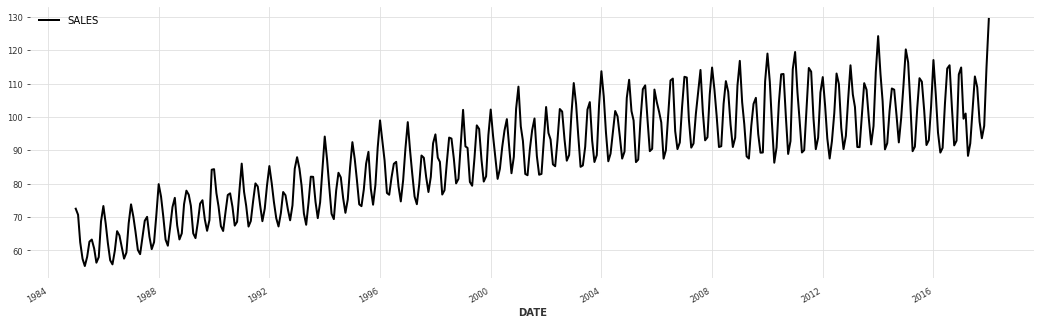

In [ ]:
# if the source is a dataframe: create a time series object from a dataframe's column
ts = TimeSeries.from_dataframe(df, time_col = "DATE", value_cols = "SALES") 


# plot the observations
plt.figure(100, figsize=(18, 5))
ts.plot();

In [ ]:
# check for seasonality, via ACF
mseas=MSEAS
for m in range(2, MSEAS):
    is_seasonal, mseas = check_seasonality(ts, m=m, alpha=ALPHA, max_lag=MSEAS)
    if is_seasonal:
        break

print("seasonal? " + str(is_seasonal))
if is_seasonal:
    print('There is seasonality of order {} Months'.format(mseas))

seasonal? True
There is seasonality of order 6 Months


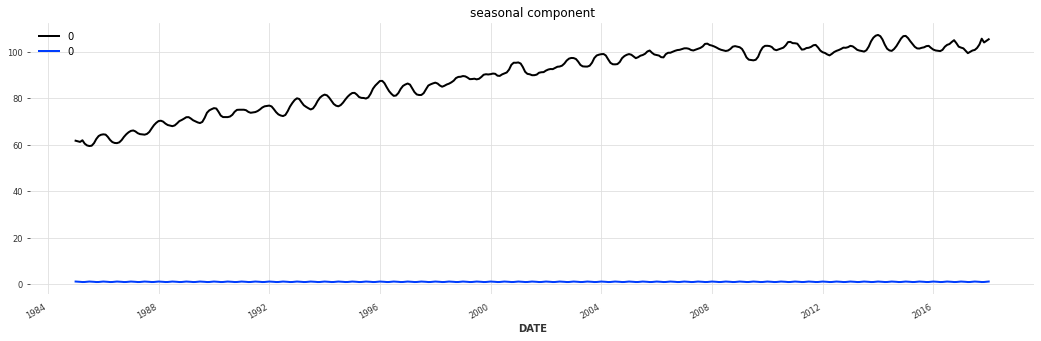

In [ ]:
# ETS analysis: try to discern trend and seasonal components
ts_trend, ts_seas = extract_trend_and_seasonality(ts=ts, freq=mseas)

plt.figure(100, figsize=(18, 5))
ts_trend.plot()
plt.title("trend component");


plt.figure(100, figsize=(18, 5))
ts_seas.plot()
plt.title("seasonal component");

In [ ]:
# train/test
if isinstance(TRAIN, str):
    split = pd.Timestamp(TRAIN)
else:
    split = TRAIN
#training_cutoff = pd.Timestamp(split)
ts_train, ts_test = ts.split_after(split)

# scale the time series on the training settransformer = Scaler()
transformer = Scaler()
ts_ttrain = transformer.fit_transform(ts_train)
ts_ttest = transformer.transform(ts_test)
ts_t = transformer.transform(ts)

In [ ]:
# create covariates: year, month, and integer index series
cov = datetime_attribute_timeseries(ts, attribute="year", one_hot=False)
cov = cov.stack(datetime_attribute_timeseries(ts, attribute="month", one_hot=False))
cov = cov.stack(TimeSeries.from_times_and_values(
                                    times=ts.time_index, 
                                    values=np.arange(len(ts)), 
                                    columns=["linear_increase"]))
cov = cov.astype(np.float32)

# train/test
train_cov, test_cov = cov.split_after(split)

# rescale the covariates: fit on the training set
scaler = Scaler()
scaler.fit(train_cov)
tcov = scaler.transform(cov)

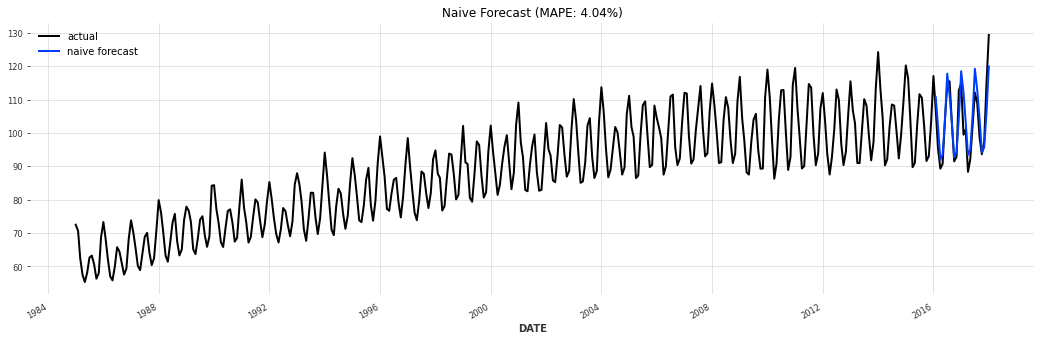

In [ ]:
# naive seasonal forecast
modelNs = NaiveSeasonal(K=mseas)
modelNs.fit(ts_train)
ts_predNs = modelNs.predict(len(ts_test))

# naive drift (trend) forecast
modelNd = NaiveDrift()
modelNd.fit(ts_train)
ts_predNd = modelNd.predict(len(ts_test))

ts_predN = ts_predNd + ts_predNs - ts_train.last_value()

plt.figure(100, figsize=(18, 5))
ts.plot(label="actual")
ts_predN.plot(label="naive forecast")
plt.title("Naive Forecast (MAPE: {:.2f}%)".format(mape(ts_test, ts_predN)))
plt.legend();

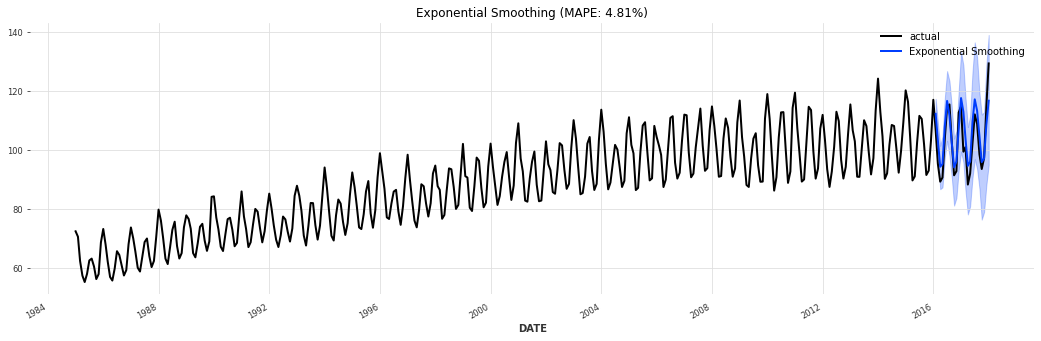

In [ ]:
# search space for best theta value: check 100 alternatives
# Exponential smoothing baseline forecast
modelX = ExponentialSmoothing(
                seasonal_periods=mseas, 
                seasonal=ModelMode.MULTIPLICATIVE)
modelX.fit(ts_train)
ts_predX = modelX.predict(  n=len(ts_test), 
                            num_samples=N_SAMPLES)

plt.figure(100, figsize=(18, 5))
ts.plot(label="actual")
ts_predX.plot(label="Exponential Smoothing")
plt.title("Exponential Smoothing (MAPE: {:.2f}%)".format(mape(ts_test, ts_predX)))
plt.legend();

In [ ]:
#TFT
model = TFTModel(   input_chunk_length=INLEN,
                    output_chunk_length=N_FC,
                    hidden_size=HIDDEN,
                    lstm_layers=LSTMLAYERS,
                    num_attention_heads=ATTHEADS,
                    dropout=DROPOUT,
                    batch_size=BATCH,
                    n_epochs=EPOCHS,
                    likelihood=QuantileRegression(quantiles=QUANTILES), 
                    # loss_fn=MSELoss(),
                    random_state=RAND, 
                    force_reset=True)
                    
                    
model.fit(  ts_ttrain, 
            future_covariates=tcov, 
            verbose=True)        

Training: 0it [00:00, ?it/s]

In [ ]:
# testing: generate predictions
ts_tpred = model.predict(   n=len(ts_test), 
                            num_samples=N_SAMPLES,   
                            n_jobs=N_JOBS)
                            
print("Do the predictions constitute a probabilistic time series?", ts_tpred.is_probabilistic)                       
                            

Predicting: 40it [00:00, ?it/s]

Do the predictions constitute a probabilistic time series? True


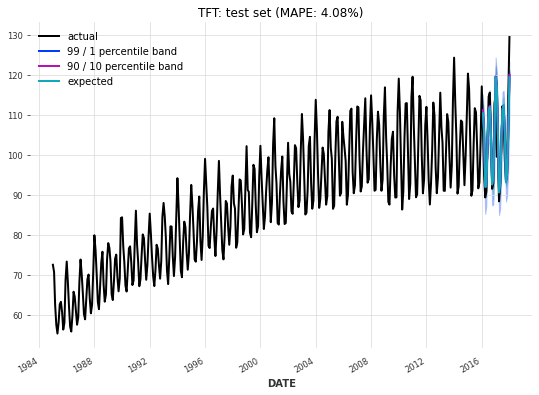

In [ ]:
# testing: helper function: plot predictions
def plot_predict(ts_actual, ts_test, ts_pred):
    
    ## plot time series, limited to forecast horizon
    plt.figure(figsize=FIGSIZE)
    
    ts_actual.plot(label="actual")                                       # plot actual
    
    ts_pred.plot(low_quantile=qL1, high_quantile=qU1, label=label_q1)    # plot U1 quantile band
    #ts_pred.plot(low_quantile=qL2, high_quantile=qU2, label=label_q2)   # plot U2 quantile band
    ts_pred.plot(low_quantile=qL3, high_quantile=qU3, label=label_q3)    # plot U3 quantile band
    ts_pred.plot(central_quantile="mean", label="expected")              # plot "mean" or median=0.5
    
    plt.title("TFT: test set (MAPE: {:.2f}%)".format(mape(ts_test, ts_pred)))
    plt.legend();  
    
    
    
 # testing: call helper function: plot predictions
ts_pred = transformer.inverse_transform(ts_tpred)
plot_predict(ts, ts_test, ts_pred)

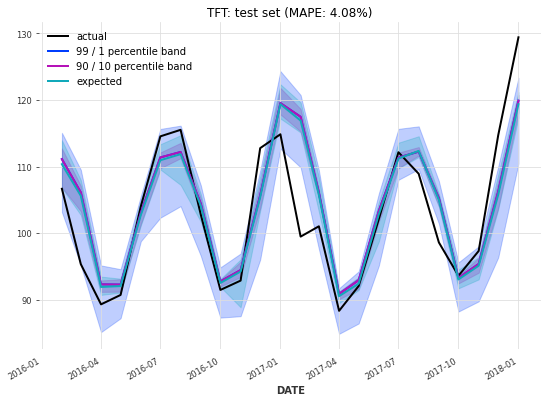

In [ ]:
# testing: call helper function: plot predictions, focus on test set
ts_pred = transformer.inverse_transform(ts_tpred)
ts_actual = ts[ ts_tpred.start_time(): ts_tpred.end_time() ]  # actual values in forecast horizon
plot_predict(ts_actual, ts_test, ts_pred)

In [ ]:
# testing: collect the prediction percentiles in a dataframe dfY
dfY = pd.DataFrame()

# helper method: calculate percentiles of predictions
def predQ(ts_tpred, q):
    ts_t = ts_tpred.quantile_timeseries(q)         # percentile of predictions
    ts = transformer.inverse_transform(ts_t)       # inverse-transform the percentile
    s = TimeSeries.pd_series(ts)
    header = "Q" + format(int(q*100), "02d")
    dfY[header] = s

# fill Actual column into the new dataframe
dfY["Actual"] = TimeSeries.pd_series(ts_actual)

# call helper function: percentiles of predictions
quantiles = [0.5, qU1, qU2, qU3, qL3, qL2, qL1]
_ = [predQ(ts_tpred, q) for q in quantiles]
dfY.iloc[np.r_[0:2, -2:0]]

,Actual,Q50,Q99,Q95,Q90,Q10,Q05,Q01
DATE,,,,,,,,
2016-02-01,106.67,111.12,115.07,113.95,112.73,106.88,106.80,103.16
2016-03-01,95.35,106.12,109.53,107.99,107.11,103.29,102.72,95.19
2017-12-01,114.72,106.26,110.01,108.83,107.81,103.80,103.59,96.37
2018-01-01,129.40,119.89,123.33,121.17,120.76,118.17,117.35,110.48


start: 1987-09-01 00:00:00
months: 364


  0%|          | 0/1 [00:00<?, ?it/s]

Predicting: 40it [00:00, ?it/s]

100%|██████████| 1/1 [00:05<00:00,  5.05s/it]


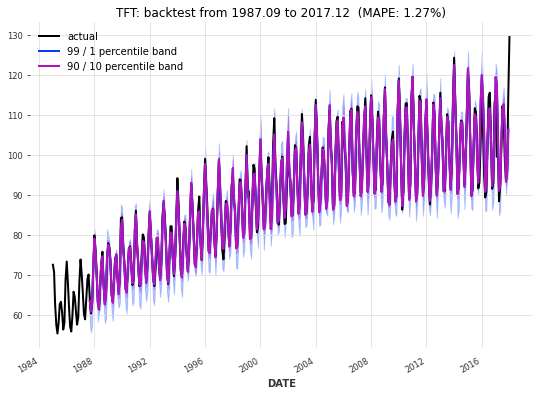

In [ ]:
# backtest the model: predictions vs actual values

# start: at 10% of time series
STARTBACKT = ts.get_timestamp_at_point(point=max(0.2, INLEN))  
print("start:",STARTBACKT)

# forecast horizon: until end of test period
tdiff = (   pd.to_datetime(ts.end_time()).to_period("M") - 
            pd.to_datetime(STARTBACKT).to_period("M")).n
print("months:",tdiff)

ts_tbacktest = model.historical_forecasts(  series=ts_t,
                                            past_covariates=None, 
                                            future_covariates=tcov,
                                            start=STARTBACKT,  
                                            num_samples=N_SAMPLES,
                                            forecast_horizon=tdiff,
                                            stride=12,
                                            last_points_only=False,
                                            retrain=False,
                                            verbose=True)
                                            
                                            
# backtesting: helper function: plot backtest predictions
def plot_backtest(ts_backtest, ts_actual, transformer):
    plt.figure(figsize=FIGSIZE)
    ts_actual.plot(label="actual")
    ts_backtest.plot(low_quantile=qL1, high_quantile=qU1, label=label_q1)
    ts_backtest.plot(low_quantile=qL3, high_quantile=qU3, label=label_q3)
    plt.legend()
    MAPE = "MAPE: {:.2f}%".format(mape(ts_actual, ts_backtest))
    plt.title(  "TFT: backtest from " + \
                format(ts_backtest.start_time(), "%Y.%m") + \
                " to " + format(ts_backtest.end_time(), "%Y.%m") + \
                "  (" + MAPE + ")");
       
       
# backtesting: call helper function: plot backtest
ts_backtest = transformer.inverse_transform(ts_tbacktest)

plot_backtest(  ts_backtest=concatenate(ts_backtest),
                ts_actual=ts,
                transformer=transformer)    

start: 1985-01-01 00:00:00 ; end: 2022-01-01 00:00:00


Predicting: 40it [00:00, ?it/s]

start: 2016-02-01 00:00:00 ; end: 2022-01-01 00:00:00


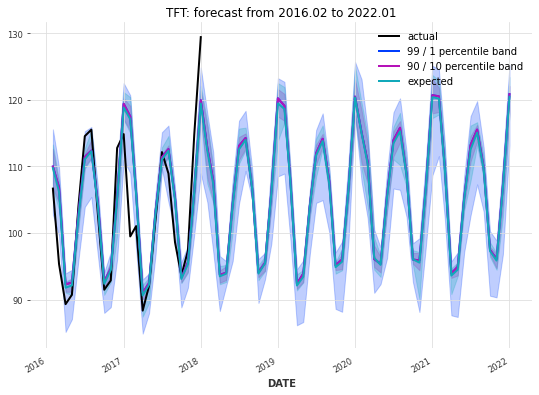

In [ ]:
# create future covariates: year, month, integer index
FC_HORIZ = 72                       # months after end of training set
start = ts.start_time()
n_per = len(ts_train) + FC_HORIZ    # set a maximum horizon to create covariates for

# create covariates from beginning of training data to end of forecast horizon
ts_year = datetime_attribute_timeseries(
                pd.date_range(start=start, periods=n_per, freq="MS"),  #, closed="right"),
                attribute="year", 
                one_hot=False)
ts_month = datetime_attribute_timeseries(
                pd.date_range(start=start, periods=n_per, freq="MS"),  
                attribute="month", 
                one_hot=False)
cov = ts_year.stack(ts_month)
# combine year and month with integer index as third covariate
cov = cov.stack(TimeSeries.from_times_and_values(
                times=cov.time_index, 
                values=np.arange(n_per), 
                columns=['linear_increase']))

cov = cov.astype(np.float32)
tcov = scaler.transform(cov)
print("start:", cov.start_time(), "; end:",cov.end_time())



# generate future, out-of-sample predictions
ts_tpred = model.predict(n=FC_HORIZ, future_covariates=tcov, num_samples=N_SAMPLES)
print("start:", ts_tpred.start_time(), "; end:",ts_tpred.end_time())
ts_pred = transformer.inverse_transform(ts_tpred)

plt.figure(figsize=FIGSIZE)
    
ts_actual = ts.slice_intersect(other=ts_pred)
ts_actual.plot(label="actual")     

ts_pred.plot(low_quantile=qL1, high_quantile=qU1, label=label_q1)    # plot U1 quantile band
ts_pred.plot(low_quantile=qL3, high_quantile=qU3, label=label_q3)    # plot U3 quantile band
ts_pred.plot(central_quantile="mean", label="expected")              # plot "mean" or median=0.5
plt.title(  "TFT: forecast" + \
            " from " + format(ts_tpred.start_time(), "%Y.%m") + \
            " to " + format(ts_tpred.end_time(), "%Y.%m"));  
plt.legend(); 

In [ ]:
# forecast: collect the prediction percentiles in a dataframe
dfY = pd.DataFrame()
# call helper function predQ: percentiles of predictions
_ = [predQ(ts_tpred, q) for q in quantiles]

dfY["Actual"] = TimeSeries.pd_series(ts_actual)

dfY.iloc[np.r_[0:2, -2:0]]

,Q50,Q99,Q95,Q90,Q10,Q05,Q01,Actual
DATE,,,,,,,,
2016-02-01,109.98,115.56,113.29,112.63,106.83,106.64,102.76,106.67
2016-03-01,106.86,109.85,107.87,107.32,104.50,103.47,99.61,95.35
2021-12-01,107.13,110.55,109.37,108.89,104.34,102.40,96.80,NaN
2022-01-01,120.84,125.18,123.40,122.06,117.93,117.75,113.18,NaN


In [ ]:
import os
mpath = os.path.abspath(os.getcwd()) + "\_TFTmodel.pth.tar"
print("saved model:", mpath)
model.save_model(mpath)

saved model: /content\_TFTmodel.pth.tar


Predicting: 0it [00:00, ?it/s]

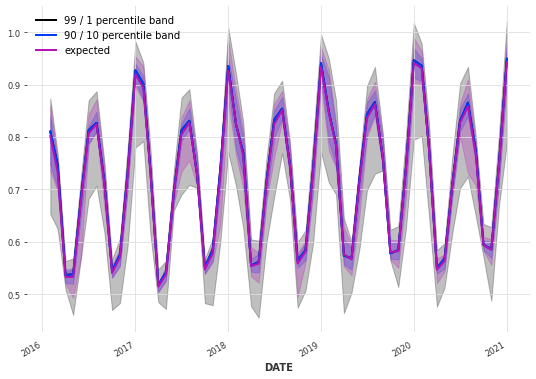

In [ ]:
# load a saved model and generate n=60 predictions
mTFT = model.load_model(mpath)
ts_tpred = mTFT.predict(n=60, future_covariates=tcov, num_samples=N_SAMPLES)

plt.figure(figsize=FIGSIZE)
         
ts_tpred.plot(low_quantile=qL1, high_quantile=qU1, label=label_q1)    # plot U1 quantile band
ts_tpred.plot(low_quantile=qL3, high_quantile=qU3, label=label_q3)    # plot U3 quantile band
ts_tpred.plot(central_quantile="mean", label="expected")              # plot "mean" or median=0.5
    
plt.legend(); 

In [ ]:
# randomized gridsearch
parameters = {  "input_chunk_length":[16, 32], 
                "hidden_size":[32, 64], 
                "lstm_layers":[2], 
                "num_attention_heads":[2, 3, 4], 
                "dropout":[0.1], 
                "batch_size":[32, 64], 
                "n_epochs":[1000],
                "output_chunk_length":[2,4]
                }

res = TFTModel.gridsearch(    
                            parameters=parameters,
                            series=ts_ttrain, 
                            future_covariates=tcov, 
                            val_series=ts_ttest,   
                            start=0.1,                 # starting point in training set 
                            last_points_only=False, 
                            metric=mape, 
                            reduction=np.mean, 
                            n_jobs=N_JOBS, 
                            n_random_samples=0.99,      # % of full search space to evaluate
                            verbose=True)
bestmodel, dict_bestparams = res

  0%|          | 0/47 [00:00<?, ?it/s]

In [ ]:
# training
bestmodel.fit(  ts_ttrain, 
                future_covariates=tcov, 
                verbose=True)
                
                
n_FC = len(ts_test)
ts_tpred =  bestmodel.predict(n_FC)
ts_pred = transformer.inverse_transform(ts_tpred)
MAPE = "MAPE after randomized gridsearch: {:.2f}%".format(mape(ts_actual, ts_pred))
print(MAPE)